# Using `pandas` to explore firm accounting data

Useful: Chapters 2.2, 3.2, and 9 will be helpful in this assignment. 

I've given you a list of firms from 2020 with variables
- "gvkey", "lpermno", "lpermno" = different datasets use different identifiers for firms
- "fyear" = the fiscal year the remaining variable apply to 
- "gsector" = gsector, an industry classification (see [the wiki article on GICS](https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard))
- "state" = of headquarters
- "tic" = ticker
- various accounting statistics

This data is a small slice of Compustat, which is a professional grade dataset that contains accounting data from SEC filings. 

In [2]:
import pandas as pd
import numpy as np
# from eda import insufficient_but_starting_eda
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime

# this file can be found here: https://github.com/LeDataSciFi/data/blob/main/Firm%20Year%20Datasets%20(Compustat)/firms2020.csv
# if you click on the file, then click "raw", you'll be at the url below,
# which contains the raw data. pandas can download/load it without saving it locally!
url = 'https://github.com/LeDataSciFi/data/raw/main/Firm%20Year%20Datasets%20(Compustat)/firms2020.csv'
firms_df = pd.read_csv(url).drop_duplicates('tic')

Create the variables:

In [3]:
firms_df = (firms_df
            .assign(log_assets  = np.log(firms_df['at']), 
                    leverage    = (firms_df['dlc']+firms_df['dltt'])/firms_df['at'],
                    cash_at     = firms_df['che']  / firms_df['at'],
                    capx_at     = firms_df['capx'] / firms_df['at'],
                    xrd_at      = firms_df['xrd']  / firms_df['at'],
                    capx_ratio  = firms_df['capx'] / (firms_df['capx']+firms_df['xrd']),
                   )
)

# we need to use leverage to create the last variable, but we can't refer to leverage
# inside the assign() that creates it, so we just do it after that assign(), either in 
# second assign() call, or like this:
firms_df['ind_med_lev'] = firms_df.groupby('gsector')['leverage'].transform('median')
    

In a rigorous project, we would have to make decisions about how to deal with observations with suspiciously low assets. 

In this dataset, the typical solution researchers make is to drop observations with missing, suspicious, or negative assets/sales. 

In [3]:
vars_to_desc = ['at','log_assets','leverage','cash_at','capx_at','xrd_at','capx_ratio','ind_med_lev']
firms_df[vars_to_desc].describe().T.style.format("{:,.2f}") # the .T transposes the table to fit on screen

,count,mean,std,min,25%,50%,75%,max
at,"1,213.00","32,225.12","153,377.96",0.65,774.17,"3,235.42","14,397.42","2,819,627.00"
log_assets,"1,213.00",7.98,2.36,-0.43,6.65,8.08,9.57,14.85
leverage,"1,170.00",0.27,0.22,0.00,0.08,0.25,0.41,1.60
cash_at,"1,210.00",0.18,0.18,0.00,0.05,0.12,0.24,1.00
capx_at,931.00,0.03,0.03,0.00,0.01,0.02,0.04,0.29
xrd_at,591.00,0.07,0.15,0.00,0.01,0.03,0.09,2.09
capx_ratio,527.00,0.45,0.34,0.00,0.14,0.39,0.74,1.00
ind_med_lev,"1,208.00",0.25,0.11,0.07,0.20,0.24,0.34,0.44


Q4: Produce the following statistics **for each** of those four types of firms (combos of industry/leverage bin):
- the number of observations
- the number of unique firms (use a different function than `count` or `len`)
- the distribution of $cash\_at$: mean, std, min, max

HINT: Use `pivot_table()` or `groupby` (but not both).

In [4]:
# First, do the filter (the order doesn't matter)

subsample = firms_df.query('gsector in [45,20]').copy() 

# Second, create the high_leverage "indicator" variable

subsample.eval('high_leverage = leverage > ind_med_lev',inplace=True) 

# replace high_lev with nan whenever there are NaN values of leverage

mask = (subsample["leverage"].isnull()) | (subsample["ind_med_lev"].isnull())
subsample.loc[mask,"high_leverage"] = np.nan

C:\Users\DonsLaptop\AppData\Local\Temp\ipykernel_25800\3071691444.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  subsample.loc[mask,"high_leverage"] = np.nan


The answer can be found with two groupbys (e.g. `subsample.groupby(['gsector','high_leverage'])['tic'].nunique()`) or this pivot table command:

In [5]:
subsample.pivot_table(
    index="gsector", columns="high_leverage", values="GVKEY", aggfunc=["count", "nunique"]
).style.format("{:.0f}")

Let's look at the distribution of cash/assets. A pivot table could also work. 

In [6]:
subsample.groupby(['gsector','high_leverage'])['cash_at'].describe().style.format("{:.2f}")

Q5: Which of the four types of firms has the highest capx ratio? (The capx ratio reflects a focus on "tangible investment" instead of "intangible" investment)

Insert cell(s) below this one as needed to finish this Part.

In [7]:
# subsample.pivot_table(index='gsector',columns='high_leverage',values='at').style.format("{:.2f}")
subsample.groupby(['gsector','high_leverage'])['capx_ratio'].mean()

gsector  high_leverage
20.0     False            0.532586
         True             0.592786
45.0     False            0.289294
         True             0.254792
Name: capx_ratio, dtype: float64

## Part 4 - Finance applications 

Check out the finance applications chapter (9) of the textbook for help on this portion. 

### Part 4a - Covid era industry return volatility

For this part, use the firms in the subsample from part 3. 

Get their tickers from the data. Then copy code from `handouts/factor_loading_simple.ipynb` into this file and modify it so that
- it uses the firms in the subsample from part 3
- downloads stock prices from Feb 1 2020 to Apr 30 2020

- HINT: Some stocks wouldn't download because of a problem with the ticker (usually they are delisted now). Ignore these and keep going. I was able to download prices for 345 firms and had 20,636 observations with a return value. 

Then, compute daily returns for each firm.

Q6: Output `.describe()` for the return variable across all observations at once.

In [8]:
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import yfinance as yf

stocks = subsample['tic'].to_list() #or list(...)
start = datetime(2020, 2, 1)
end = datetime(2020, 4, 30)

# load
stock_prices =yf.download(stocks, start , end)

[*********************100%%**********************]  405 of 405 completed


61 Failed downloads:
['CREE', 'OIIM', 'TNAV', 'ALJJ', 'EPAY', 'ZEN', 'SVMK', 'AVLR', 'MTOR', 'FISV', 'GFN', 'CCMP', 'UEPS', 'PCYG', 'KBAL', 'PRCP', 'CTXS', 'AIMC', 'IIVI', 'JCOM', 'MXIM', 'SINO', 'EGOV', 'NUAN', 'CSCW', 'DSPG', 'KSU', 'INS', 'AVYA', 'DCT', 'KNL', 'CDK', 'CUB', 'RP', 'FEYE', 'NATI', 'MTSC', 'MOG.A', 'FBHS', 'VOLT', 'USX', 'IPHI', 'NCR', 'NAV', 'EXFO', 'IEC', 'INFO', 'USAK', 'PS', 'AQUA', 'PFPT', 'BRKS', 'YELL']: Exception('%ticker%: No timezone found, symbol may be delisted')
['FLOW', 'FROG', 'AZEK', 'CRSR', 'U', 'DNB', 'DBD']: Exception("%ticker%: Data doesn't exist for startDate = 1580533200, endDate = 1588219200")
['AENZ']: Exception('%ticker%: No data found, symbol may be delisted')


This is copied from the other file:

In [ ]:
# stock_prices.index = stock_prices.index.tz_localize(None)        # change yf date format to match pdr
stock_prices = stock_prices.filter(like='Adj Close')               # reduce to just columns with this in the name
stock_prices.columns = stock_prices.columns.get_level_values(1)    # tickers as col names, works no matter order of tics

stock_prices = stock_prices.stack().swaplevel().sort_index().reset_index()
stock_prices.columns = ['Firm','Date','Adj Close']

print(stock_prices['Firm'].nunique()) # number of firms we downloaded stock info for

stock_prices['ret'] = stock_prices.groupby('Firm')['Adj Close'].pct_change()
stock_prices

In [ ]:
# add high_leverage + gsector variables (for Q7, doing it here)
stock_prices= stock_prices.merge(subsample,
                                 left_on='Firm',right_on='tic')

In [ ]:
# let's look at just the return variable we just made
stock_prices['ret'].describe()

Q7: For each of our 4 firm types, report the average vol 

(By vol, I mean the standard deviation.) 

- HINT 1: First, compute the standard deviation of returns **for each** firm over this sample. 
- HINT 2: Then, using those firm level vol estimates, take the average volatility within each combination of high_leverage and leverage bin. Output this.

To answer the questions, we need the high_leverage and gsector variables added into this dataset so we can see the portfolios. One way to do this is to MERGE that in from the other datasets. As long as you merge "Firm" into "tic", you'll get what you need.

In [10]:
(stock_prices
    # compute std for each firm
    # I added leverage/sector to the groupby JUST to keep those vars around
    .groupby(['tic','gsector','high_leverage'])['ret'].std()   
    
    # now, we have 3 index vars. groupby can use index vars, just 
    # by adding "level=" inside groupby
    # and we have a single Series var (without a name) so we just take a mean
    # instead of writing ['ret'].mean()
    .groupby(level=['gsector','high_leverage']).mean()
) 

gsector  high_leverage
20.0     False            0.055373
         True             0.069099
45.0     False            0.058454
         True             0.056014
Name: ret, dtype: float64

### Portfolio analysis

Load the `toy` dataset below and answer Q8-10 with it:
- Q8. If you invested $100 (total) in the portfolio 1 firms at date 0, how much would you end up with after date 3?  
    - Assume that you divide your \$100 equally between the firms in the portfolio at the start, but after that, you don't touch your portfolio. 
    - One of the textbook pages will come in handy here, but you should think about this before you proceed. 
    - Work out the answer by hand! Then you'll know if your code is right or wrong. 
- Q9. Repeat this for all portfolios in the dataset. 
  - HINT: My code to answer Q9 and Q8 are the same. 
- Q10. Plot the cumulative returns to the 4 portfolios. 
  - You'll need to track how much is in your portfolios every day. So if you used `prod()` for Q8 or Q9, you might want to consider another similar function. 



In [5]:
# a test data set:

toy = pd.DataFrame({'firm':['A','A','A','B','B','B','C','C','C','D','D','D'],
                    'port':[1,1,1,1,1,1,2,2,2,2,2,2],
                    'date':[1,2,3,1,2,3,1,2,3,1,2,3],
                    'ret':[.1,.1,.1,0,0,0,.05,.05,.05,.05,.05,.05]})

toy

,firm,port,date,ret
0,A,1,1,0.10
1,A,1,2,0.10
2,A,1,3,0.10
3,B,1,1,0.00
4,B,1,2,0.00
5,B,1,3,0.00
6,C,2,1,0.05
7,C,2,2,0.05
8,C,2,3,0.05
9,D,2,1,0.05


Q8 and Q9:


In [6]:
# end of period returns are in this output dataframe 
port_daily_ret = (
    toy
    
    # first cumulate the returns for each asset
    
    .assign(R=1+toy['ret'])
    .assign(cumret = lambda x: x.groupby(['firm'])['R'].cumprod())
    
    # then calculate the cumulative portfolio return at each point in time
    
    .groupby(['port','date'])['cumret'].mean()
        
) 

port_daily_ret   # print all of the data 

# Q8 and Q9:
# port_daily_ret.groupby('port').tail(1)*100 # how much do I have at the end?

port  date
1     1       1.050000
      2       1.105000
      3       1.165500
2     1       1.050000
      2       1.102500
      3       1.157625
Name: cumret, dtype: float64

Q10: 

port
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
Name: cumret, dtype: object

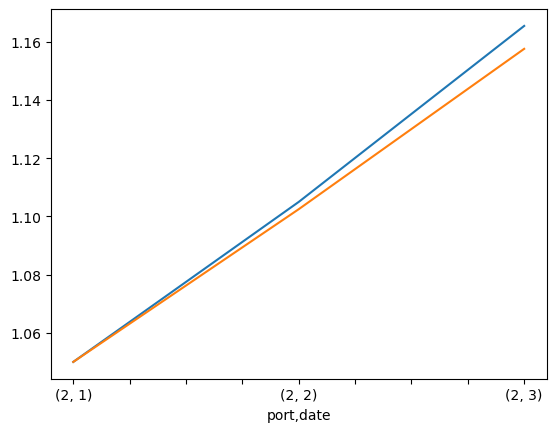

In [7]:
#10:
port_daily_ret.groupby('port').plot()

## Q11

Virtually identical code will work, but I'm showing code with some tweaks to demonstrate another way forward:

In [14]:
# first, cumulate returns
stock_prices['cumret'] = \
(
    stock_prices
    .assign(R=1+stock_prices['ret'])
    .groupby(['tic'])
    ['R'].cumprod()
)    

# to find my holdings as of a date, apply the portfolio weights
# here, its an equally split portfolio, so mean() works. 

port_cumrets = stock_prices.groupby(['high_leverage','gsector','Date'])['cumret'].mean()

# to display the answers, I'm going to reformat this (not required)
port_cumrets = port_cumrets.unstack(level=[0,1])

port_cumrets.tail(1)*100 # how much do I have at the end?

high_leverage      False                True            
gsector             20.0      45.0       20.0       45.0
Date                                                    
2020-04-29     87.068669  94.07816  81.961082  91.658932

## Q12 

This plot is ugly but functional. We will learn how to improve this next week:

<Axes: xlabel='Date'>

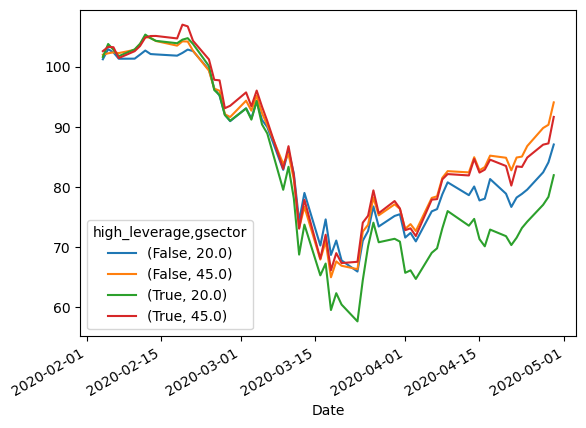

In [15]:
port_cumrets.plot()